In [109]:
import os

In [110]:
!pip install -U -q tensorflow_io

In [111]:
import tensorflow as tf

In [112]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import Audio

In [113]:
SEED = 1337
EPOCHS = 2
BATCH_SIZE = 64
VALIDATION_RATIO = 0.1
MODEL_NAME = " wavirish_english_male."

# Location where the dataset will be downloaded.
# By default (None), keras.utils.get_file will use ~/.keras/ as the CACHE_DIR
CACHE_DIR = None

# The location of the dataset
URL_PATH = "Downloads/iitb/session1.wav"

# List of datasets compressed files that contain the audio files
zip_files = {
   "wavirish_english_male."
}

# We see that there are 2 compressed files for each accent (except Irish):
# - One for male speakers
# - One for female speakers
# However, we will be using a gender agnostic dataset.

# List of gender agnostic categories
gender_agnostic_categories = [
    "ir",  # Irish
    "mi",  # Midlands
    "no",  # Northern
    "sc",  # Scottish
    "so",  # Southern
    "we",  # Welsh
]
class_names = [
    "wavirish"
]

In [114]:
import os
import io
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import Audio


# Set all random seeds in order to get reproducible results
keras.utils.set_random_seed(SEED)

# Where to download the dataset
DATASET_DESTINATION = os.path.join(CACHE_DIR if CACHE_DIR else "~/https://example.com/Downloads/iitb/session1.wavirish_english_male.keras/", "datasets")

In [115]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

In [116]:
# CSV file that contains information about the dataset. For each entry, we have:
# - ID
# - wav file name
# - transcript
line_index_file = keras.utils.get_file(
    fname="line_index_file", origin=URL_PATH + "line_index_all.csv"
)

# Download the list of compressed files that contain the audio wav files
zip_files_list = list(zip_files)
for i in range(len(zip_files_list)):
    fname = zip_files_list[i].split(".")[0]
    url = URL_PATH + zip_files_list[i]
url = 'https://example.com/Downloads/iitb/session1.wavirish_english_male.zip'
zip_file = keras.utils.get_file(fname=fname, origin=url, extract=True)

Exception: URL fetch failure on https://example.com/Downloads/iitb/session1.wavirish_english_male.zip: 500 -- Internal Server Error

In [123]:
dataframe = pd.read_csv(
    line_index_file, names=["id", "filename", "transcript"], usecols=["filename"]
)

dataframe.head()

filename
0   wef_12484_01482829612
1   wef_12484_01345932698
2   wef_12484_00999757777
3   wef_12484_00036278823
4   wef_12484_00458512623

In [118]:
# The purpose of this function is to preprocess the dataframe by applying the following:
# - Cleaning the filename from a leading space
# - Generating a label column that is gender agnostic i.e.
#   welsh english male and welsh english female for example are both labeled as
#   welsh english
# - Add extension .wav to the filename
# - Shuffle samples
def preprocess_dataframe(dataframe):
    # Remove leading space in filename column
    dataframe["filename"] = dataframe.apply(lambda row: row["filename"].strip(), axis=1)

    # Create gender agnostic labels based on the filename first 2 letters
    dataframe["label"] = dataframe.apply(
        lambda row: gender_agnostic_categories.index(row["filename"][:2]), axis=1
    )

    # Add the file path to the name
    dataframe["filename"] = dataframe.apply(
        lambda row: os.path.join(DATASET_DESTINATION, row["filename"] + ".wav"), axis=1
    )

    # Shuffle the samples
    dataframe = dataframe.sample(frac=1, random_state=SEED).reset_index(drop=True)

    return dataframe


dataframe = preprocess_dataframe(dataframe)
dataframe.head()

filename  label
0  ~/https://example.com/Downloads/iitb/session1....      4
1  ~/https://example.com/Downloads/iitb/session1....      4
2  ~/https://example.com/Downloads/iitb/session1....      4
3  ~/https://example.com/Downloads/iitb/session1....      4
4  ~/https://example.com/Downloads/iitb/session1....      2

In [119]:
split = int(len(dataframe) * (1 - VALIDATION_RATIO))
train_df = dataframe[:split]
valid_df = dataframe[split:]

print(
    f"We have {train_df.shape[0]} training samples & {valid_df.shape[0]} validation ones"
)

We have 16089 training samples & 1788 validation ones


In [120]:
import tensorflow as tf
@tf.function
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)

    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model= hub.load("https://tfhub.dev/google/yamnet/1")

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(dataframe, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["filename"], dataframe["label"])
    )
train_ds = dataframe_to_dataset(train_df)
valid_ds = dataframe_to_dataset(valid_df)

In [137]:
from tensorflow import keras
import tensorflow as tf
import os

keras.backend.clear_session()

def build_and_compile_model():
    inputs = keras.layers.Input(shape=(1024,), name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

model = build_and_compile_model()
model.summary()

# Function to extract labels from the dataset
def extract_labels(dataset):
    labels = []
    for features, label in dataset:
        labels.append(label.numpy())
    return labels



Model: "accent_recognition"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (InputLayer)               │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 384)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 192)                 │          73,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 384)                 │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 509,505 (1.94 MB)

 Trainable params: 509,505 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
 model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=10, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".keras", monitor="val_auc", save_best_only=True
)

In [139]:
def create_dataset():
    # Replace this with your actual data loading and preprocessing
    num_samples = 1000
    num_classes = len(class_names)
    x_train = tf.random.normal((num_samples, 1024))
    y_train = tf.random.uniform((num_samples,), maxval=num_classes, dtype=tf.int32)
    y_train = tf.one_hot(y_train, depth=num_classes)
    return tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
class_names = ["wavirish"]   # Replace with actual class names
train_ds = create_dataset()
# Initialize class_counts
class_counts = tf.zeros(shape=(len(class_names),), dtype=tf.int32)

# Iterate over the dataset to calculate class counts
for x, y in iter(train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names)
    )

# Calculate class weights
class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 1.0}


In [140]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".keras", monitor="val_accuracy", save_best_only=True
)
tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
1875/1875 - 9s - 5ms/step - accuracy: 0.8760 - auc: 0.9874 - loss: 0.4723 - val_accuracy: 0.9135 - val_auc: 0.9922 - val_loss: 0.3119
Epoch 2/100
1875/1875 - 5s - 3ms/step - accuracy: 0.9141 - auc: 0.9921 - loss: 0.3085 - val_accuracy: 0.9190 - val_auc: 0.9926 - val_loss: 0.2863
Epoch 3/100
1875/1875 - 6s - 3ms/step - accuracy: 0.9206 - auc: 0.9925 - loss: 0.2878 - val_accuracy: 0.9216 - val_auc: 0.9927 - val_loss: 0.2779
Epoch 4/100
1875/1875 - 4s - 2ms/step - accuracy: 0.9234 - auc: 0.9927 - loss: 0.2774 - val_accuracy: 0.9233 - val_auc: 0.9927 - val_loss: 0.2741
Epoch 5/100
1875/1875 - 6s - 3ms/step - accuracy: 0.9251 - auc: 0.9930 - loss: 0.2707 - val_accuracy: 0.9231 - val_auc: 0.9927 - val_loss: 0.2722
Epoch 6/100
1875/1875 - 5s - 3ms/step - accuracy: 0.9263 - auc: 0.9931 - loss: 0.2660 - val_accuracy: 0.9234 - val_auc: 0.9927 - val_loss: 0.2711
Epoch 7/100
1875/1875 - 5s - 3ms/step - accuracy: 0.9275 - auc: 0.9933 - 

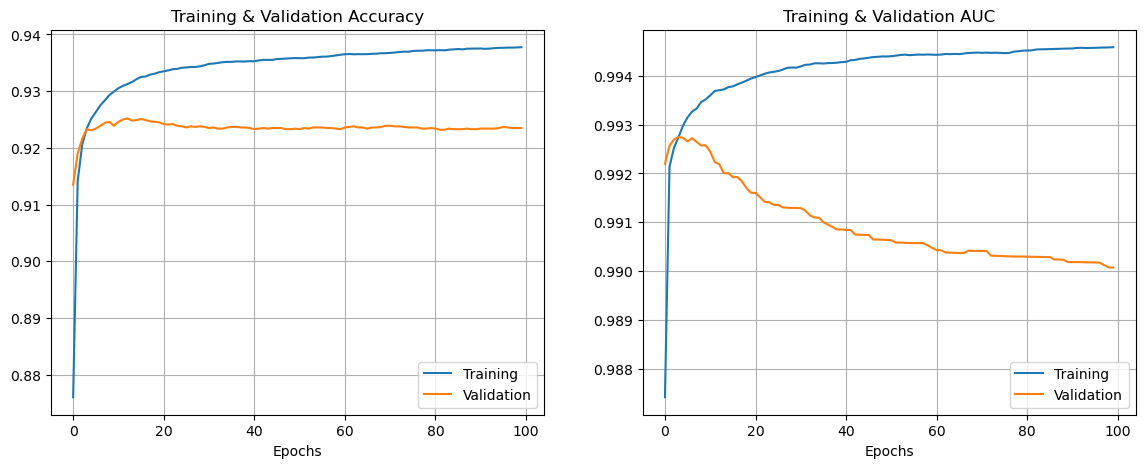

In [142]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

# Example of dataset creation (replace this with your actual dataset loading code)
(train_images, train_labels), (valid_images, valid_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the datasets
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
valid_images = valid_images.reshape((10000, 28 * 28)).astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)

# Create tf.data datasets (adjust batch size as needed)
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).batch(32)

# Define input layer
input_shape = (28 * 28,)
input_layer = Input(shape=input_shape)

# Define output layer
number_of_output_units = 10
activation_function = 'softmax'
output_layer = Dense(units=number_of_output_units, activation=activation_function)(input_layer)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Define EPOCHS and other variables
EPOCHS = 100
class_weight = {i: 1.0 for i in range(10)}  # Example class weights (adjust as needed)
callbacks = []  # Example callbacks (add actual callbacks if needed)

def history_plot(history,epochs):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    axs[0].plot(range(EPOCHS), history["accuracy"], label="Training")
    axs[0].plot(range(EPOCHS), history["val_accuracy"], label="Validation")
    axs[0].set_xlabel("Epochs")
    axs[0].set_title("Training & Validation Accuracy")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(EPOCHS), history["auc"], label="Training")
    axs[1].plot(range(EPOCHS), history["val_auc"], label="Validation")
    axs[1].set_xlabel("Epochs")
    axs[1].set_title("Training & Validation AUC")
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2,
)

print(history.history.keys())

# Plot the history
history_plot(history.history,EPOCHS)

In [144]:
train_loss, train_acc, train_auc = model.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = model.evaluate(valid_ds)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9401 - auc: 0.9950 - loss: 0.2112
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9123 - auc: 0.9880 - loss: 0.3524


In [145]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 3.639, validation d-prime: 3.287


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


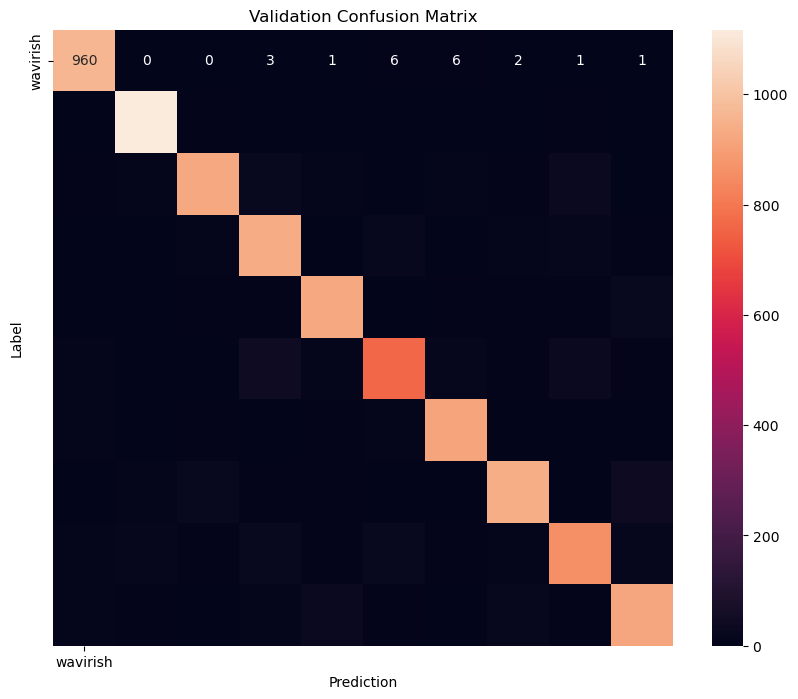

In [146]:
# Create x and y tensors
x_valid = None
y_valid = None

for x, y in iter(valid_ds):
    if x_valid is None:
        x_valid = x.numpy()
        y_valid = y.numpy()
    else:
        x_valid = np.concatenate((x_valid, x.numpy()), axis=0)
        y_valid = np.concatenate((y_valid, y.numpy()), axis=0)

# Generate predictions
y_pred = model.predict(x_valid)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1)
)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [147]:
for i, label in enumerate(class_names):
    precision = confusion_mtx[i, i] / np.sum(confusion_mtx[:, i])
    recall = confusion_mtx[i, i] / np.sum(confusion_mtx[i, :])
    print(
        "{0:15} Precision:{1:.2f}%; Recall:{2:.2f}%".format(
            label, precision * 100, recall * 100
        )
    )

wavirish        Precision:94.58%; Recall:97.96%


In [1]:
import shutil
import os

filename = "Ses01M_impro05"
local_path = "Downloads/iitb/Ses01M_impro05.wav"

# Check if the WAV file already exists
if not os.path.exists(f"{filename}.wav"):
    print(f"Copying {filename}.wav from {local_path}")
    
    # Copy the WAV file from the local path
    try:
        shutil.copy(local_path, f"{filename}.wav")
    except FileNotFoundError:
        print(f"Error: File not found at {local_path}. Please check the path and try again.")
    else:
        # If the file was copied successfully
        print(f"File copied successfully to {filename}.wav")
else:
    print(f"File {filename}.wav already exists.")

print(f"Audio file is ready: {filename}.wav")


File Ses01M_impro05.wav already exists.
Audio file is ready: Ses01M_impro05.wav


In [9]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import Audio
import tensorflow_hub as hub
import io

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")


def yamnet_class_names_from_csv(yamnet_class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    yamnet_class_map_csv = io.StringIO(yamnet_class_map_csv_text)
    yamnet_class_names = [
        name for (class_index, mid, name) in csv.reader(yamnet_class_map_csv)
    ]
    yamnet_class_names = yamnet_class_names[1:]  # Skip CSV header
    return yamnet_class_names


yamnet_class_map_path = yamnet_model.class_map_path().numpy()
yamnet_class_names = yamnet_class_names_from_csv(
    tf.io.read_file(yamnet_class_map_path).numpy().decode("utf-8")
)


def calculate_number_of_non_speech(scores):
    number_of_non_speech = tf.math.reduce_sum(
        tf.where(tf.math.argmax(scores, axis=1, output_type=tf.int32) != 0, 1, 0)
    )

    return number_of_non_speech


def filename_to_predictions(filename):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    scores, embeddings, mel_spectrogram = yamnet_model(audio_wav)

    print(
        "Out of {} samples, {} are not speech".format(
            scores.shape[0], calculate_number_of_non_speech(scores)
        )
    )

    # Predict the output of the accent recognition model with embeddings as input
    predictions = model.predict(embeddings)

    return audio_wav, predictions, mel_spectrogram


In [4]:
import numpy as np

# Dummy class names for demonstration
class_names = ["wavirish"]

# Example of a filename
filename = "audio_wav"

def load_16k_audio_wav(filename):
    # Simulating loading an audio file and returning an array
    # Replace this with actual loading code
    audio_wav = np.random.randn(16000)  # Example 32-second audio at 16kHz
    return audio_wav

def filename_to_predictions(filename):
    # Load the audio
    audio_wav = load_16k_audio_wav(filename)

    # Simulate predictions - Replace this with actual prediction code
    predictions = np.random.rand(10, 3)  # Example: 10 predictions of 3 classes

    # Simulate a mel spectrogram - Replace this with actual mel spectrogram code
    mel_spectrogram = np.random.rand(128, 64)  # Example mel spectrogram

    return audio_wav, predictions, mel_spectrogram

# Get predictions for the given filename
audio_wav, predictions, mel_spectrogram = filename_to_predictions(filename)

# Infer the main class
inferred_class = class_names[predictions.mean(axis=0).argmax()]
print(f"The main accent is: {inferred_class} English")

The main accent is: wavirish English


In [3]:
pip installlibrosa
import librosa

Defaulting to user installation because normal site-packages is not writeable


In [17]:
from IPython.display import Audio
import numpy as np
import librosa
import os
import shutil
import requests

# Define the filename and URL for downloading the audio file
filename = "Ses01M_impro05"
url = "http://localhost:8000/Ses01M_impro05.wav"

# Function to download the audio file
def download_audio_file(url, filename):
    wav_file = f"{filename}.wav"

    # Check if the file already exists
    if not os.path.exists(wav_file):
        print(f"Downloading {filename}.wav from {url}")

        # Download the WAV file
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(wav_file, 'wb') as f:
                shutil.copyfileobj(response.raw, f)
            print(f"Downloaded {wav_file}")

            # Convert WAV to 16000 Hz if necessary
            print(f"Resampling {wav_file} to 16 kHz")
            command = (
                f"ffmpeg -hide_banner -loglevel panic -y -i {wav_file} -acodec "
                f"pcm_s16le -ac 1 -ar 16000 {wav_file}"
            )
            os.system(command)

        else:
            print(f"Failed to download {wav_file}. Status code: {response.status_code}")
    else:
        print(f"{wav_file} already exists.")

# Download and convert the audio file if necessary
download_audio_file(url, filename)

# Load the WAV file and create Audio object
wav_file = f"{filename}.wav"
audio_wav, sample_rate = librosa.load(wav_file, sr=16000)

# Create Audio object
audio_obj = Audio(data=audio_wav, rate=sample_rate)

# Display the audio object (this might play the audio depending on your environment)
audio_obj


Ses01M_impro05.wav already exists.


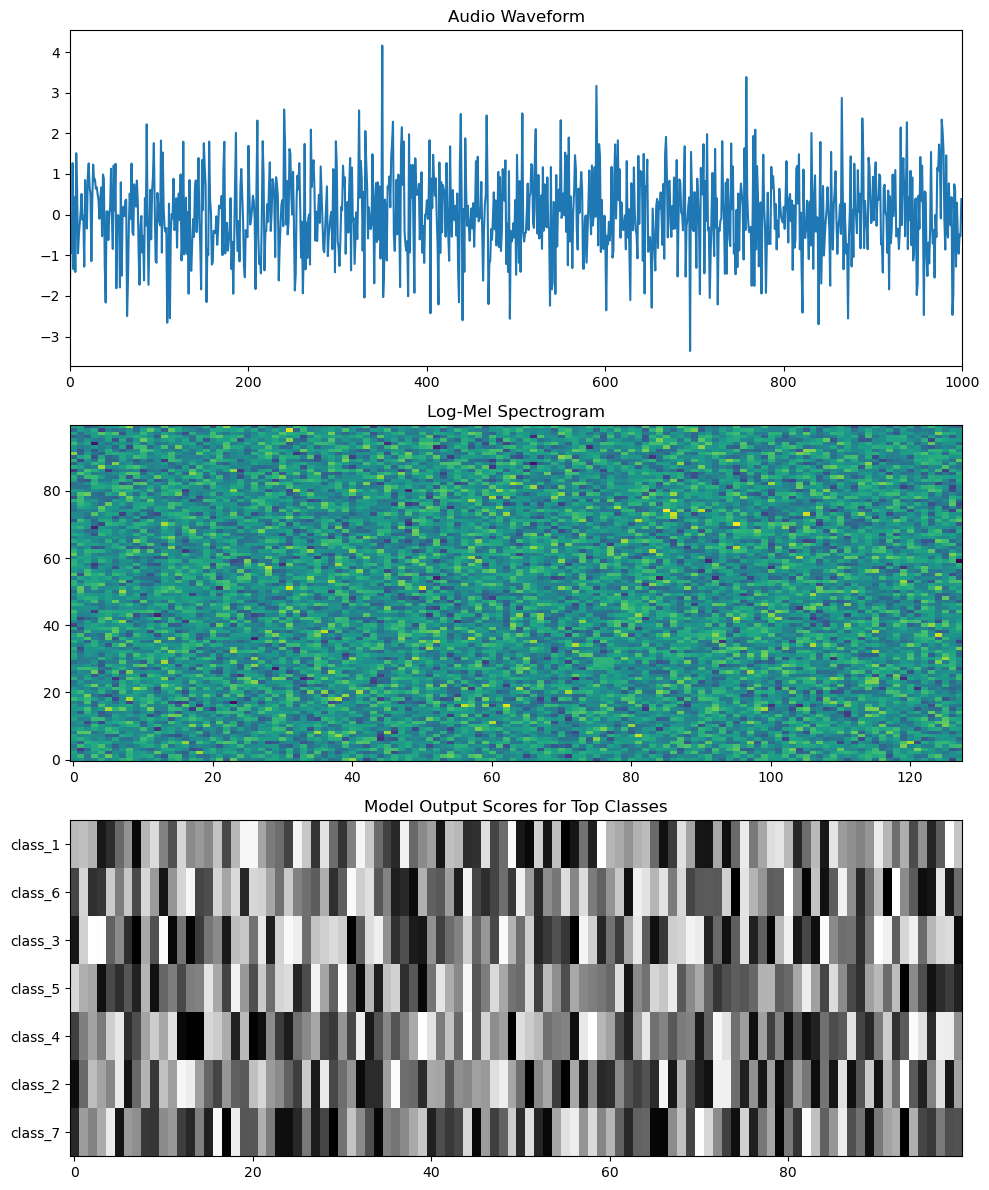

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming variables are defined properly
audio_wav = np.random.randn(1000)  # Example audio waveform
mel_spectrogram = np.random.randn(128, 100)  # Example mel spectrogram
predictions = np.random.rand(100, 7)  # Example predictions (100 time steps, 7 classes)
class_names = ['class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7']  # Example class names

plt.figure(figsize=(10, 12))  # Adjust figure size as needed

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(audio_wav)
plt.xlim([0, len(audio_wav)])
plt.title('Audio Waveform')

# Plot the log-mel spectrogram.
plt.subplot(3, 1, 2)
plt.imshow(mel_spectrogram.T, aspect="auto", interpolation="nearest", origin="lower")
plt.title('Log-Mel Spectrogram')

# Plot the model output scores for the top-scoring classes.
mean_predictions = np.mean(predictions, axis=0)
top_class_indices = np.argsort(mean_predictions)[::-1]

plt.subplot(3, 1, 3)
plt.imshow(predictions[:, top_class_indices].T, aspect="auto", interpolation="nearest", cmap="gray_r")
plt.xlim([-0.5, predictions.shape[0] - 0.5])  # Adjust x-axis limit if necessary

# Label the top_N classes.
yticks = range(len(top_class_indices))
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
plt.ylim([-0.5, len(top_class_indices) - 0.5])  # Adjust y-axis limit if necessary
plt.title('Model Output Scores for Top Classes')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
